In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset

In [38]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                      download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)

trainset_sub = Subset(trainset, indices=range(3200))
testset_sub = Subset(testset, indices=range(600))

trainloader = torch.utils.data.DataLoader(trainset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
class model_CIFAR10(nn.Module):
    def __init__(self):
        super(model_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 32, 64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(32, 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], 6 * 6 * 32)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x
    
    def train(self, batches):
        losses = []
        for epoch in range(3):
            running_loss = 0.0
            for i, batch in enumerate(batches):
                X_batch, y_batch = batch   

                self.optimizer.zero_grad()
            
                y_pred = self.forward(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
            
                running_loss += loss.item()
            
                if i % 200 == 199:
                    print('{} loss: {}'.format(i + 1 + epoch * 800, 
                                               round(running_loss / 200, 
                                                     3)))
                    losses.append(running_loss)
                    running_loss = 0.0 
                
        plt.plot(np.arange(len(losses)), losses)
        plt.show()
        print('train ended')
        
    def test(self, data):
        class_correct = list(0 for i in range(10))
        class_total = list(0 for i in range(10))
        classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        
        with torch.no_grad():
            for i, batch in enumerate(data):
                images, labels = batch
                y_pred = self.forward(images)
                _, predicted = torch.max(y_pred, 1)
                
                checker = (predicted.detach() == labels)
                
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += checker[i].item()
                    class_total[label] += 1
                    
        for idx, name_class in enumerate(classes):
            print('Accuracy of {}: {}'.format(name_class, round(class_correct[idx] / class_total[idx] * 100, 3)))
        
        print('Mean accuracy = {}'.format(sum(class_correct) / sum(class_total) * 100))

In [34]:
class mixedPool(nn.Module):
    def __init__(self, kernel_size, stride, alpha = 0.5, padding = 0):
        super(mixedPool, self).__init__()
        alpha = torch.FloatTensor([alpha])
        self.alpha = nn.Parameter(alpha)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
         
    def forward(self, x):
        x = self.alpha * F.max_pool2d(x,
                                      self.kernel_size,
                                      self.stride,
                                      self.padding) + (1 - self.alpha) * F.avg_pool2d(x,
                                                                                      self.kernel_size,
                                                                                      self.stride, 
                                                                                      self.padding)
        return x

In [35]:
class model_CIFAR10_mixedPool(model_CIFAR10):
    def __init__(self):
        super(model_CIFAR10_mixedPool, self).__init__()
        self.pool1 = mixedPool(2, 2)
        self.pool2 = mixedPool(2, 2)

200 loss: 2.299
400 loss: 2.244
600 loss: 2.128
800 loss: 2.104
1000 loss: 2.007
1200 loss: 2.011
1400 loss: 2.009
1600 loss: 1.971
1800 loss: 1.974
2000 loss: 1.926
2200 loss: 1.893
2400 loss: 1.859


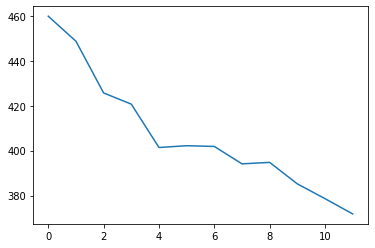

train ended


In [39]:
m3_mixed = model_CIFAR10_mixedPool()
m3_mixed.train(trainloader)

In [40]:
m3_mixed.test(testloader)

Accuracy of plane: 40.909
Accuracy of car: 50.0
Accuracy of bird: 8.621
Accuracy of cat: 0.0
Accuracy of deer: 1.961
Accuracy of dog: 46.774
Accuracy of frog: 67.143
Accuracy of horse: 42.105
Accuracy of ship: 31.746
Accuracy of truck: 43.662
Mean accuracy = 34.5
